Figure 3: Timing of shock predicting cells

In [1]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
# %matplotlib ipympl
# Fig3a = Fig(num=3, grid=(4, 4), size=(8.5, 6.5), fontsize=6, constrained_layout=False)  # size=(7.2, 5.3) if not scaling properly
# print(Fig3a.fig.get_size_inches())
# Fig3astats = Fig(num="Figure 3 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=3) 
# print(Fig3astats.fig.get_size_inches())
# Fig3acomb = FigMirror(Fig3a, Fig3astats)

In [2]:
def allmax(a):
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    if len(all_) == 1:
        return np.array(all_, dtype=int).squeeze()
    else:
        return np.around(np.mean(all_)).astype(int).squeeze()

In [3]:
def snake_plot(rasters, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
        
    peak_id = np.array([allmax(rast) for rast in rasters])
    sort_ids = np.argsort(peak_id)
    sns.heatmap(rasters[sort_ids])
    
    return ax, peak_id
    

In [10]:
MD1 = fa.MotionTuning('Marble20', 'Shock', 1)

In [14]:

MD1.gen_pe_rasters(buffer_sec=(2,2))
freeze_cells = MD1.select_cells('freeze_fine')
rast_use = MD1.pe_rasters['freeze_onset'][freeze_cells]

In [24]:
buffer_sec = (2, 2)
sr_match = 20
srs = [20]
np.sum(buffer_sec*sr_match)
times = np.arange(-buffer_sec[0], buffer_sec[1], 1/srs[0])
np.interp(rast_use[0],[])

(80,)

In [28]:
times_sr = np.arange(-buffer_sec[0], buffer_sec[1], 1/MD1.sr_image)
times_sr

array([-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        1.77635684e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
        1.20000000e+00,  1.30000000e+00,  1.40000000e+00,  1.50000000e+00,
        1.60000000e+00,  1.70000000e+00,  1.80000000e+00,  1.90000000e+00])

In [25]:
def multiInterp2(x, xp, fp):
    i = np.arange(x.size)
    j = np.searchsorted(xp, x) - 1
    d = (x - xp[j]) / (xp[j + 1] - xp[j])
    return (1 - d) * fp[i, j] + fp[i, j + 1] * d

In [39]:
rast_use.mean(axis=1).shape

(3, 40)

<AxesSubplot:>

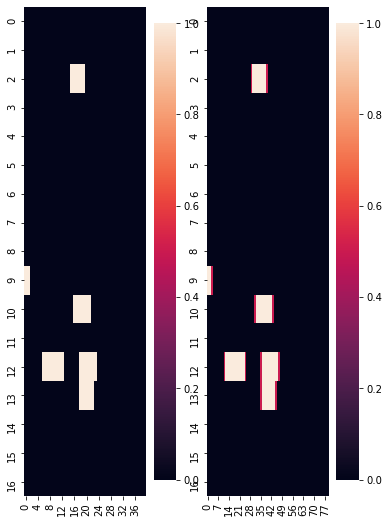

In [37]:
_, ax = plt.subplots(1, 2, figsize=(6, 9))
sns.heatmap(rast, ax=ax[0])
sns.heatmap(rast_interp, ax=ax[1])

In [32]:
rast = rast_use[0]
rast_interp = []
for act in rast:
    rast_interp.append(np.interp(times, times_sr, act))
rast_interp = np.array(rast_interp)

In [52]:
def freeze_group_snake_plot(group, arena, day, buffer_sec=(2, 2), sr_match=20):
    """Plot freeze-tuned cells for each group/day"""
    
    # Set up times
    times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)
    
    freeze_rasts_mean = []
    srs = []
    for mouse in group:
        MD1 = fa.MotionTuning(mouse, arena, day)
        MD1.gen_pe_rasters(buffer_sec=buffer_sec)
        freeze_cells = MD1.select_cells('freeze_fine')
        rast_use = MD1.pe_rasters['freeze_onset'][freeze_cells]
        
        if MD1.sr_image != sr_match:  # interpolate values if sample rate doesn't match to make data compatible
            rast_mean_interp = []
            times_sr = np.arange(-buffer_sec[0], buffer_sec[1], 1/MD1.sr_image)
            for act in rast_use.mean(axis=1):
                rast_mean_interp.append(np.interp(times, times_sr, act))
            freeze_rasts_mean.append(rast_mean_interp)
        else:
            freeze_rasts_mean.append(rast_use.mean(axis=1))

    freeze_rasts_mean_comb = np.concatenate(freeze_rasts_mean, axis=0)

#     assert np.mean(srs) == srs[0], 'Fix code to work with different sample rates'
#     times = np.arange(-buffer_sec[0], buffer_sec[1], 1/srs[0])

#     peak_id = [np.argmax(rast_mean) for rast_mean in freeze_rasts_mean_comb]
#     peak_id = np.array([allmax(rast_mean) for rast_mean in freeze_rasts_mean_comb])
#     sort_ids = np.argsort(peak_id)
#     _, ax = plt.subplots()
#     sns.heatmap(freeze_rasts_mean_comb[sort_ids])
    ax, peak_id = snake_plot(freeze_rasts_mean_comb)
    ax.set_xticks([0, int(len(times)/2), len(times)])
    ax.set_xticklabels([-buffer_sec[0], 0, buffer_sec[1]])
    
    return ax, peak_id, times

In [5]:
# Pre-allocate dictionary
rast_dict = {'Learners': {}, 'Non-Learners': {}, 'ANI': {}}

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(6, 3))
for day in [-2, -1, 4, 1, 2]:
    ax[0].plot(np.sort(rast_dict['Learners'][day]), np.arange(len(rast_dict['Learners'][day])))
#     sns.ecdfplot(rast_dict['Learners'][day], ax=ax[1])
    sns.histplot(rast_dict['Learners'][day], bins=np.arange(-2, 2, 0.1))
ax[0].legend([-2, -1, 4, 1, 2])


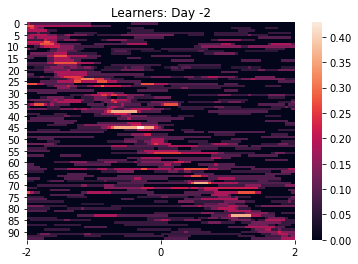

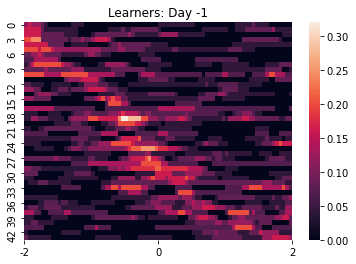

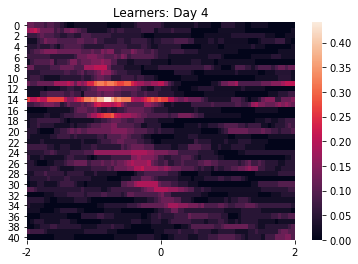

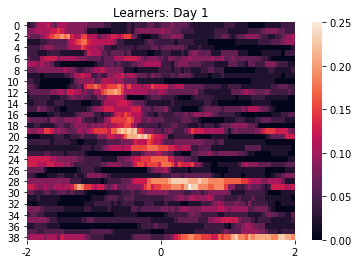

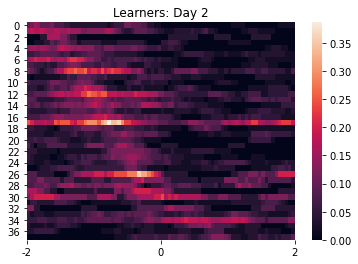

In [45]:
group, lgroup = 'Learners', err.learners
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    
    ax, lrn_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[lrn_ids]
    
    ax.set_title(f'{group}: Day {day}')

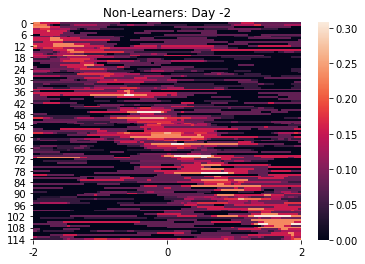

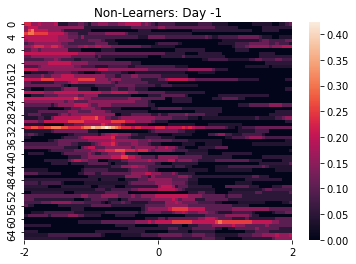

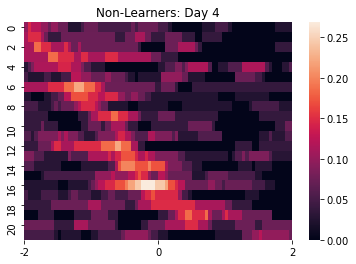

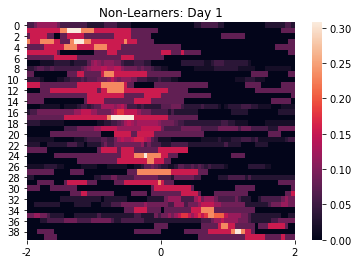

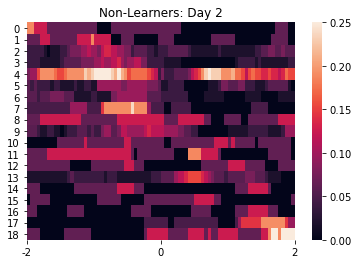

In [46]:
group, lgroup = 'Non-Learners', err.nonlearners
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    
    ax, nlrn_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[nlrn_ids]
    ax.set_title(f'{group}: Day {day}')

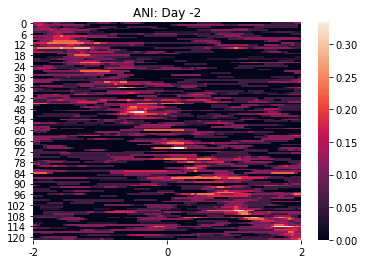

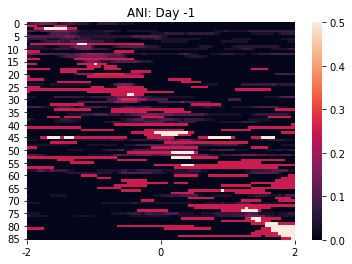

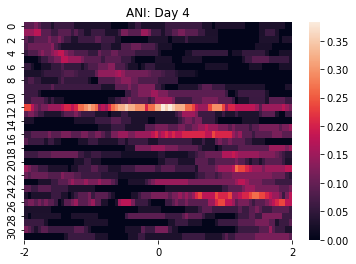

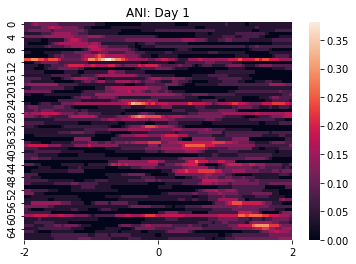

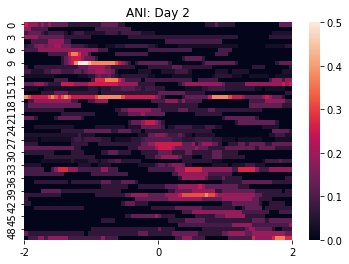

In [53]:
# Need to fix and add in Marble20 which has a 20Hz sample rate
# group, lgroup = 'ANI', ['Marble17', 'Marble18', 'Marble19', 'Marble25']
group, lgroup = 'ANI', err.ani_mice_good
arena = 'Shock'
for day in [-2, -1, 4, 1, 2]:
    ax, ani_ids, times = freeze_group_snake_plot(lgroup, arena, day)
    rast_dict[group][day] = times[ani_ids]
    ax.set_title(f'{group}: Day {day}')

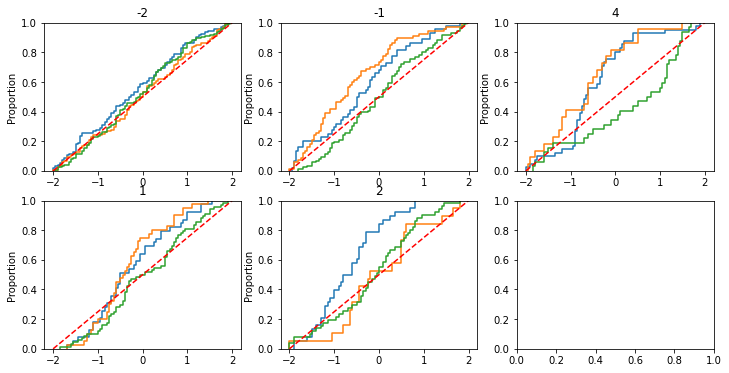

In [54]:
_, ax = plt.subplots(2, 3, figsize=(12, 6))

for a, day in zip(ax.reshape(-1), [-2, -1, 4, 1, 2]):
    for group in ['Learners', 'Non-Learners', 'ANI']:
        sns.ecdfplot(rast_dict[group][day], ax=a)
    a.plot([-2, 2], [0, 1], 'r--')
    a.set_title(str(day))

[-0.2971014492753608, -0.24697802197802043, -0.04543269230769057]
[-0.4841463414634133, -0.668181818181817, 0.32500000000000207]
[-0.4499999999999986, -0.19999999999999835, -0.004201680672267124]


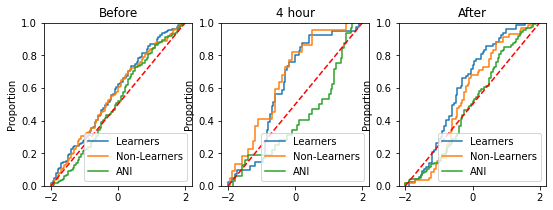

In [55]:
# Group by Before-4-After
_, ax = plt.subplots(1, 3, figsize=(9, 3))
for a, day_group, sesh_time in zip(ax.reshape(-1), [[-2, -1], [4], [1, 2]], ['Before', '4 hour', 'After']):
    means_print = []
    for group in ['Learners', 'Non-Learners', 'ANI']:
        rast_use = []
        for day in day_group:
            rast_use.append(rast_dict[group][day])
        sns.ecdfplot(np.concatenate(rast_use), ax=a)
        means_print.append(np.mean(np.concatenate(rast_use)))
    print(means_print)
    a.plot([-2, 2], [0, 1], 'r--')
    a.legend(['Learners', 'Non-Learners', 'ANI'])
    a.set_title(sesh_time)

<AxesSubplot:ylabel='Proportion'>

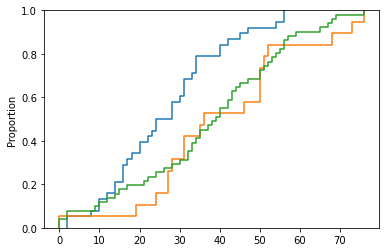

In [56]:
_, ax = plt.subplots()
sns.ecdfplot(lrn_ids, ax=ax)
sns.ecdfplot(nlrn_ids, ax=ax)
sns.ecdfplot(ani_ids, ax=ax)

In [ ]:
# plot mean transient event rate rasters centered on freezing

In [246]:
prop_active = MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0]
print(prop_active.mean())
print(prop_active.std())

0.012269760024725187
0.006628672267777602


In [239]:
%%time
# Code to generate shuffled PBE curves

MD1 = fa.MotionTuning('Marble11', 'Shock', 1)
PBEshuf = fa.shuffle_raster(MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0], MD1.select_events(event_type), 
                                   sr_image=MD1.sr_image, buffer_sec=buffer_sec_use, nperm=1000)
times = np.arange(-buffer_sec_use[0], buffer_sec_use[1], 1/MD1.sr_image)
shuf_times = np.matlib.repmat(times, 1, PBEshuf.shape[0]*PBEshuf.shape[1]).reshape(PBEshuf.shape)

CPU times: user 274 ms, sys: 28.7 ms, total: 303 ms
Wall time: 314 ms


CPU times: user 24.4 s, sys: 109 ms, total: 24.5 s
Wall time: 24.5 s


(0.008, 0.02)

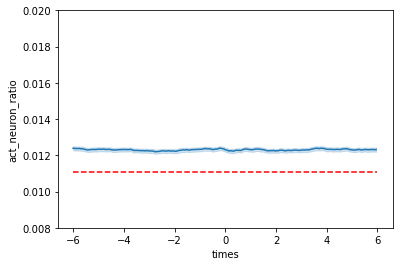

In [240]:
# This is way too slow.
%%time
PBEshuf_df = pd.DataFrame({'times': shuf_times.reshape(-1), 'act_neuron_ratio': PBEshuf.reshape(-1)})
_, ax = plt.subplots()
sns.lineplot(data=PBEshuf_df, x='times', y='act_neuron_ratio', ax=ax)
ax.plot([-6, 6], [0.0111, 0.0111], 'r--')
ax.set_ylim([0.008, 0.02])

In [107]:
buffer_sec = (6, 6)
times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)
animal_list = err.learners
nanimals = len(animal_list)
PBEdict = {}
for day in  [-2, -1, 4, 1, 2]:
    PBErast_comb, PBErast_combz, times_comb = [], [], []
    for animal in animal_list:
        MD1 = fa.MotionTuning(animal, 'Shock', day)
        PBErast = fa.get_PE_raster(MD1.PSAbool.sum(axis=0), MD1.select_events(event_type), 
                                   sr_image=MD1.sr_image, buffer_sec=buffer_sec_use)
        # Sum up cells active and divide by total to get proportion active before each event
        PBErast_prop = PBErast.mean(axis=0)/MD1.PSAbool.shape[0]
        
        # z-score proportions
        prop_active = MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0]
        PBErast_propz = (PBErast_prop - prop_active.mean())/prop_active.std()
        
        if MD1.sr_image != sr_match:  # interpolate values if sample rate doesn't match to make data compatible
            rast_mean_interp = []
            times_sr = np.arange(-buffer_sec[0], buffer_sec[1], 1/MD1.sr_image)
            PBErast_comb.extend(np.interp(times, times_sr, PBErast_prop))
            PBErast_combz.extend(np.interp(times, times_sr, PBErast_propz))
        else:
            PBErast_comb.extend(PBErast_prop) 
            PBErast_comb.extend(PBErast_propz)
        times_comb.extend(times)  # aggregate times
        
        PBEshuf = fa.shuffle_raster(MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0], MD1.select_events(event_type), 
                                   sr_image=MD1.sr_image, buffer_sec=buffer_sec_use, nperm=1000)
times = np.arange(-buffer_sec_use[0], buffer_sec_use[1], 1/MD1.sr_image)
shuf_times = np.matlib.repmat(times, 1, PBEshuf.shape[0]*PBEshuf.shape[1]).reshape(PBEshuf.shape)

In [249]:
def get_group_PBE_rasters(animal_list, group_name, buffer_sec_use=(6, 6), event_type='freeze_onset', sr_match=20):
    """Gets rasters of population level calcium activity centered on specified events default = freeze onset"""
    
    # Set up times for all PBE rasters
    times = np.arange(-buffer_sec[0], buffer_sec[1], 1/sr_match)
    
    nanimals = len(animal_list)
    PBEdict = {}
    for day in  [-2, -1, 4, 1, 2]:
        PBErast_comb, PBErast_combz, times_comb = [], [], []
        for animal in animal_list:
            MD1 = fa.MotionTuning(animal, 'Shock', day)
            PBErast = fa.get_PE_raster(MD1.PSAbool.sum(axis=0), MD1.select_events(event_type), 
                                       sr_image=MD1.sr_image, buffer_sec=buffer_sec_use)
            # Sum up cells active and divide by total to get proportion active before each event
            PBErast_prop = PBErast.mean(axis=0)/MD1.PSAbool.shape[0]
            
            # z-score proportions
            prop_active = MD1.PSAbool.sum(axis=0)/MD1.PSAbool.shape[0]
            PBErast_propz = (PBErast_prop - prop_active.mean())/prop_active.std()
        
            if MD1.sr_image != sr_match:  # interpolate values if sample rate doesn't match to make data compatible
                rast_mean_interp = []
                times_sr = np.arange(-buffer_sec[0], buffer_sec[1], 1/MD1.sr_image)
                PBErast_comb.extend(np.interp(times, times_sr, PBErast_prop))
                PBErast_comb.extend(np.interp(times, times_sr, PBErast_propz))
            else:
                PBErast_comb.extend(PBErast_prop) 
                PBErast_combz.extend(PBErast_propz)
            times_comb.extend(times)  # aggregate times
            
        # Assemble into dataframes for easy plotting later on
        PBEdict[day] = pd.DataFrame({'times': np.array(times_comb).reshape(-1), 
                                     'act_neuron_ratio': np.array(PBErast_comb).reshape(-1),
                                     'act_neuron_ratio_z': np.array(PBErast_combz).reshape(-1),
                                     'group': [group_name]*len(np.array(times_comb).reshape(-1)),
                                     'day': [day]*len(np.array(times_comb).reshape(-1))})
        
    return PBEdict

In [250]:
PBElearn = get_group_PBE_rasters(err.learners, 'Learners')

In [174]:
from copy import copy
PBElearn = get_group_PBE_rasters(err.learners, 'Learners')
PBEnlearn = get_group_PBE_rasters(err.nonlearners, 'Non-Learners')
PBEani = get_group_PBE_rasters(err.ani_mice_good, 'ANI')
# PBEanisub = get_group_PBE_rasters(['Marble17', 'Marble18', 'Marble19', 'Marble25'])
control_mice_good = copy(err.learners)
control_mice_good.extend(err.nonlearners)
PBEctrl = get_group_PBE_rasters(control_mice_good, 'Control')

In [201]:
from copy import deepcopy

def add_memory_designations(df_use, before=[-2, -1], during=[4], after=[1, 2]):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df["day"] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df["day"] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df["day"] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
       # Old hardcoded method below for reference/bug checking
#     before_ind = np.where((df["d1_d2"] == "-2_-1") | (df["d1_d2"] == "-1_4"))[0]
#     during_ind = np.where(df["d1_d2"] == "4_1")[0]
#     after_ind = np.where((df["d1_d2"] == "1_2") | (df["d1_d2"] == "2_7"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df['Designation'] = desig
    
    return df

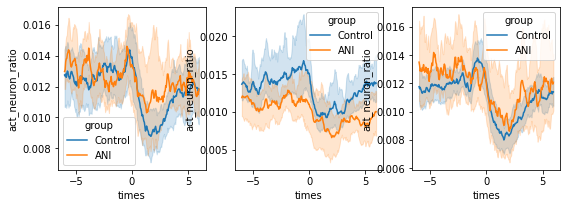

In [206]:
PBEcomb_simp2 = add_memory_designations(pd.concat(PBEcomb_simp.values()))
_, ax = plt.subplots(1, 3, figsize=(9, 3))
for a, desig in zip(ax, ['Before', '4hr', 'After']):
    sns.lineplot(data=PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig], 
                                    x='times', y='act_neuron_ratio', hue='group', ax=a)

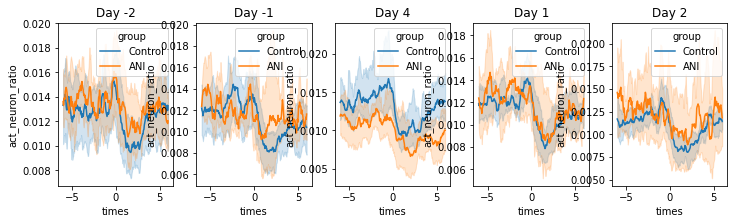

In [190]:
_, ax = plt.subplots(1, 5, figsize=(12, 3))
for a, day in zip(ax, [-2, -1, 4, 1, 2]):
    sns.lineplot(data=PBEcomb_simp[day], x='times', y='act_neuron_ratio', hue='group', ax=a)
    a.set_title(f'Day {day}')

In [196]:
PBEcomb, PBEcomb_simp = {}, {}
for day in [-2, -1, 4, 1, 2]:
    PBEcomb[day] = pd.concat([PBElearn[day], PBEnlearn[day], PBEani[day]])
    PBEcomb_simp[day] = pd.concat([PBEctrl[day], PBEani[day]])

In [81]:
def plot_group_PBE_rasters(PBEdict, group_name, days=[-2, -1, 4, 1, 2], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 5, figsize=(16, 4))
    for day, a in zip(days, ax.reshape(-1)):
        df_test = PBEdict[day]
        sns.lineplot(data=df_test, x='times', y='act_neuron_ratio', ax=a)
        a.set_xlabel('Time from freeze (s)')
        a.set_ylabel('Prop. neurons active')
        a.set_title(f'{group_name} Day {day}')
    

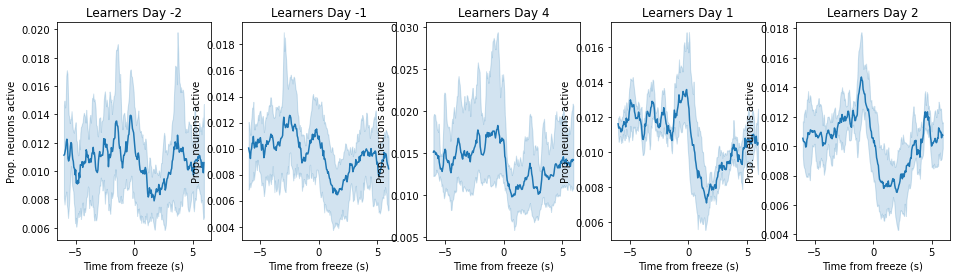

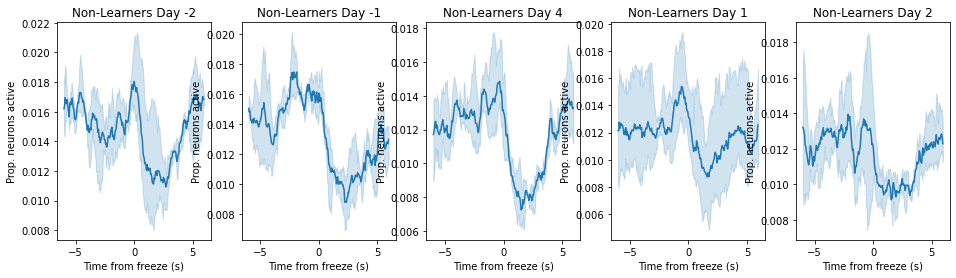

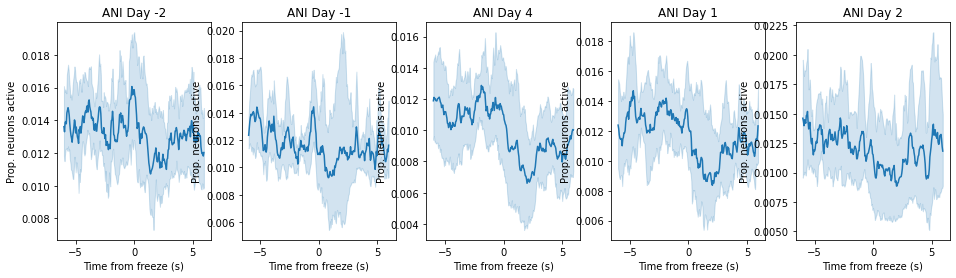

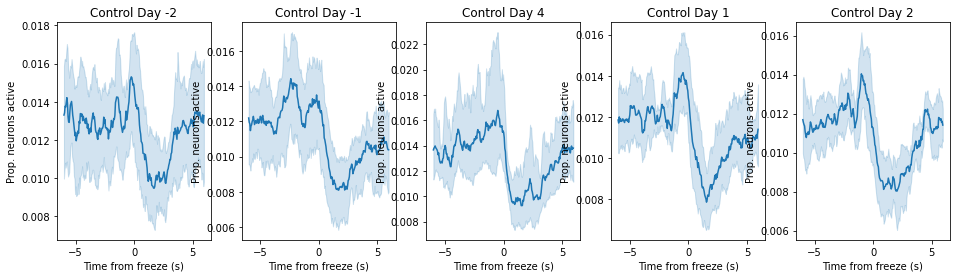

In [114]:
%matplotlib inline
plot_group_PBE_rasters(PBElearn, 'Learners')
plot_group_PBE_rasters(PBEnlearn, 'Non-Learners')
plot_group_PBE_rasters(PBEani, 'ANI')
# plot_group_PBE_rasters(PBEanisub, 'ANIsubset')
plot_group_PBE_rasters(PBEctrl, 'Control')

<IPython.core.display.Javascript object>


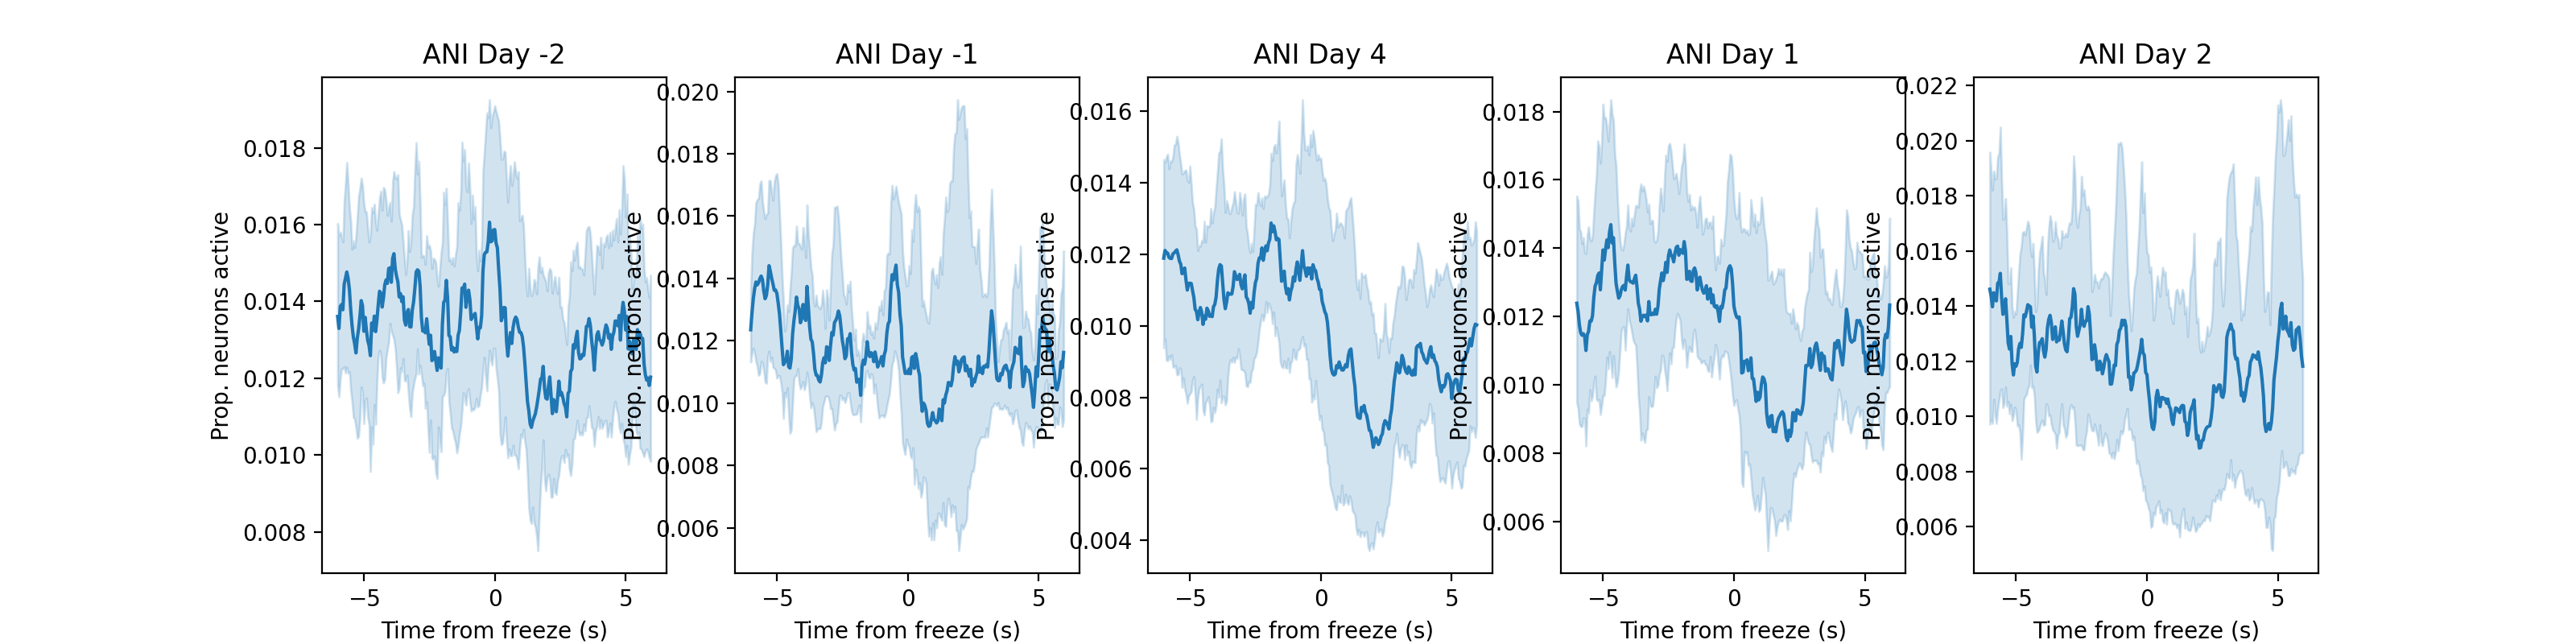

In [112]:
%matplotlib notebook
plot_group_PBE_rasters(PBEani, 'ANI')
# PBEani = get_group_PBE_rasters(['Marble17', 'Marble18', 'Marble19', 'Marble25'])

In [ ]:
# plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
# Fig3a.savefig(plot_path / 'Figure3a.pdf', scriptname='Figure3a.ipynb')
# Fig3astats.savefig(plot_path / 'Figure3stats.pdf', scriptname='Figure3a.ipynb')